# EDA in Album review ratings dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns=90

In [ ]:
data = pd.read_csv('../input/30000-albums-aggregated-review-ratings/album_ratings.csv')
data.head()

## Selecting Data from 2000

In [ ]:
data['Release Year'].unique()

In [ ]:
data_2000 = data[data['Release Year'] >= 2000].copy()
data_2000['Release Year'].unique()

## Checking if there's outliers

In [ ]:
cols = ['Metacritic Critic Score', 'Metacritic Reviews', 'Metacritic User Score', 
        'Metacritic User Reviews', 'AOTY Critic Score', 'AOTY Critic Reviews',
       'AOTY User Score', 'AOTY User Reviews']
for col in cols:
    print(data_2000[col].describe())
    print('-'*50)

There's an outlier in the Metacritic User Score, the values goes from 0 to 10 and the max value is 80, so we before making any assumption let's find which record has that outlier

In [ ]:
data_2000[data_2000['Metacritic User Score'] == 80.0]

According to Metacritic the User Score for this album is 8.0
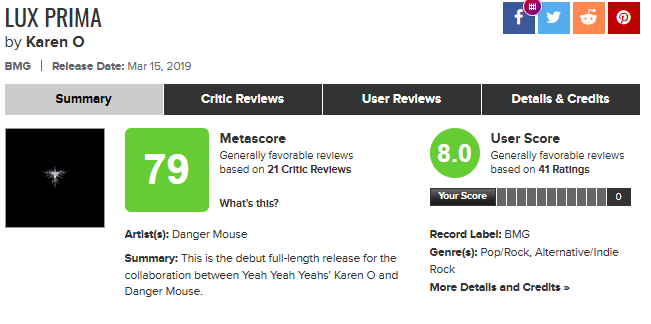
So i'm going to transform that value to the actual scale

In [ ]:
data_2000['Metacritic User Score'] = data_2000['Metacritic User Score'].replace(80.0, 8.0)
data_2000['Metacritic User Score'].describe()

## Finding and filling NaN data

In [ ]:
display(data_2000.isnull().sum())
display(data_2000.size)

First, i'm going to multiply the Metacritic User Score by 10, so in that way it has the same scale as the other columns. In the case of missing data, i'm going to fill the missing values in the Title, Release Month, Release Day, Label and Genre with "Unknown". In the case of Metacritic scores i'm going to fill them using the average user score/review and the average critic score/review according to the genre

In [ ]:
data_2000['Metacritic User Score'] = data_2000['Metacritic User Score'] * 10
cols = ['Title', 'Release Month', 'Release Day', 'Label', 'Genre']
for col in cols:
    data_2000[col].fillna('Unknown', inplace=True)
    
data_2000.isnull().sum()

In [ ]:
columns = ['Metacritic Critic Score', 'Metacritic Reviews', 'Metacritic User Score', 'Metacritic User Reviews']
for genre in data_2000['Genre'].unique():
    for col in columns:
        value = round(data_2000.loc[data_2000['Genre'] == genre,  col].mean(), 0)
        data_2000.loc[(data_2000['Genre'] == genre) &  (data_2000[col].isna()), col] = value

data_2000.isnull().sum()

There are still some NaN, let's explore them to see why weren't filled. But it looks like there might be albums that did not have any review

In [ ]:
missing = data_2000[data_2000['Metacritic User Score'].isnull()]
missing.Genre.value_counts()

In [ ]:
missing[missing['Genre'] == 'Folk Metal']

First i created a genre count to find how many rows have NaN data. Some of the genres are not that popular, like Folk Metal. But at the same time they have reviews in the AOTY columns. So i'm going to run the for loop that i wrote to fill the NaN values with the mean value for each genre using the mean value of the AOTY column.

In [ ]:
cols = [['Metacritic Critic Score', 'AOTY Critic Score'],
        ['Metacritic Reviews', 'AOTY Critic Reviews'],
        ['Metacritic User Score', 'AOTY User Score'],
        ['Metacritic User Reviews', 'AOTY User Reviews']]

for genre in data_2000['Genre'].unique():
    for col, x in cols:               
        value = round(data_2000.loc[data_2000['Genre'] == genre,  x].mean(), 0)
        data_2000.loc[(data_2000['Genre'] == genre) &  (data_2000[col].isna()), col] = value

data_2000.isnull().sum()

In [ ]:
data_2000[data_2000['Genre'] == 'Folk Metal']

To do the EDA i'm going to use the mean value for critics and users scores and the sum of the number of reviews

In [ ]:
data_2000['Critic Score'] = round(data_2000[['Metacritic Critic Score', 'AOTY Critic Score']].mean(axis=1), 0)
data_2000['Critic Reviews'] = round(data_2000[['Metacritic Reviews', 'AOTY Critic Reviews']].sum(axis=1), 0)
data_2000['User Score'] = round(data_2000[['Metacritic User Score', 'AOTY User Score']].mean(axis=1), 0)
data_2000['User Reviews'] = round(data_2000[['Metacritic User Reviews', 'AOTY User Reviews']].sum(axis=1), 0)

data_clean = data_2000[['Artist', 'Title', 'Release Month', 'Release Day', 'Release Year', 'Format',
              'Label', 'Genre', 'Critic Score', 'Critic Reviews', 'User Score', 'User Reviews']].copy()

data_clean.head()

## Analysis

### Best Albums for each year according to User Scores

In [ ]:
years = [i for i in range(2000, 2021)]
for year in years:
    data_year = data_clean[data_clean['Release Year'] == year]
    score = data_year['User Score'].max()
    secondary_df = data_year[data_year['User Score'] == score]
    artist = secondary_df['Artist'].tolist()
    album = secondary_df['Title'].tolist()
    genre = secondary_df['Genre'].tolist()
    album_format = secondary_df['Format'].tolist()
    for i in range(0, len(artist)):
        print('{}'.format(year))
        print('"{}" by {} with a score of {}. Genre: {}. Format: {}'.format(album[i], artist[i].upper(), score, genre[i], album_format[i]))
        print('-'*20)

There are 45 records on the list some years have at least two records considered as the best album of the year by the users. 2000 has two entries with "Kid A" by Radiohead and "Lift your Skinny Fist Like Antennas to Heaven" by Godspeed you! Black Emperor with a score of 90.

The year 2002 contains five entries with "Yankee Hotel Foxtrot" by Wilco, "Songs for the Deaf" by Queens of the Stone Age, "You Forgot It In People" by Broken Social Scene, "Turn On The Bright Lights" by Interpol, and "October Road" by James Taylor with a score of 88.

2003 contains 15 entries with notable mentions to "Ghosts of the Great Highway" by Sun Kil Moon, "The Black Album" by Jay-Z, "The Meadowlands" by The Wrens with a score of 86. This is also the year with the fewest score.

2016 contains five entries with notable mentions to "Blackstar" by David Bowie, which was his final studio album (he died two days after the album was released.) , "A Moon Shaped Pool" by Radiohead, and "Atrocity Exhibition" by Danny Brown with a score of 88.

2017 has two entries, "Melodrama" by Lorde and "Flower Boy" by Tyler, The Creator. In 2020 the best album so far was "Song Machine, Season One: Strange Timez" by Gorillaz.

The most significant score was 94 in 2005's "10th Avenue Freakout" by FOG, 2006's "Half The Perfect World" by Madeleine Peyroux, and 2020s "Song Machine, Season One: Strange Timez" by Gorillaz.

It's also important to mention that Radiohead had three records on the list and Kendrick Lamar had two. It also looks like rock albums were really popular in the first years of the 2000s with at least 17 entries between 2000 and 2010 after 2010 rock albums only have three entries. After 2010 the established genres are pop, hip hop, and country.

### Most hyped records by year according user reviews

In [ ]:
years = [i for i in range(2000, 2021)]
for year in years:
    data_year = data_clean[data_clean['Release Year'] == year]
    score = data_year['User Reviews'].max()
    secondary_df = data_year[data_year['User Reviews'] == score]
    artist = secondary_df['Artist'].tolist()
    album = secondary_df['Title'].tolist()
    for i in range(0, len(artist)):
        print('Most hyped record in {} was "{}" by {} with {} user reviews'.format(year, album[i], artist[i].upper(), score))
        print('-'*20)

Hype doesn't always translate into quality is one of the conclusions that we can make with this list. Most of the albums in this list aren't in the best albums list with some exceptions like Radiohead's "Kid A" (2000) and Kendrick Lamar's "good kid, m.A.A.d. city" (2007). The most hyped artist in the list is Kanye West with five entries, Radiohead has three, Lady Gaga, Kendrick Lamar, and Taylor Swift has two entries. The album with more reviews was Taylor Swift's "Folklore" in 2020 with 16,556 user reviews. The album with the fewest reviews was "Hail to the Thief" by Radiohead in 2003 with 2,123 user reviews.

### Artist that generate most hype

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))

data_artist = data_clean[['Artist', 'Critic Reviews', 'User Reviews']].copy()

critics = data_artist[['Artist', 'Critic Reviews']]
critics_group = critics.groupby('Artist').sum()
critics_group.sort_values(by=['Critic Reviews'], ascending=False, inplace=True)
sns.barplot(ax=ax[0], x='Critic Reviews', y=critics_group.index[0:10], data=critics_group[0:10])
ax[0].set_title('Critics Hype')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

users = data_artist[['Artist', 'User Reviews']]
users_group = users.groupby('Artist').sum()
users_group.sort_values(by=['User Reviews'], ascending=False, inplace=True)
sns.barplot(ax=ax[1], x='User Reviews', y=users_group.index[0:10], data=users_group[0:10])
ax[1].set_title('Users Hype')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

data_artist['total_hype'] = data_artist['Critic Reviews'] + data_artist['User Reviews']
data_artist = data_artist[['Artist', 'total_hype']]
data_artist_group = data_artist.groupby('Artist').sum()
data_artist_group.sort_values(by=['total_hype'], ascending=False, inplace=True)
sns.barplot(ax=ax[2], x='total_hype', y=data_artist_group.index[0:10], data=data_artist_group[0:10])
ax[2].set_title('Total Hype')
ax[2].set_xlabel('')
ax[2].set_ylabel('') 

plt.suptitle('Top 10 artist that generates most hype')
plt.subplots_adjust(hspace=0.3)
sns.despine(left=False, bottom=False)

For critics, Animal Collective generates the most hype followed by Kanye West and Of Montreal. For fans Taylor Swift, Kanye West and Lady Gaga head the list. In total the most hyped artist are Taylor Swift, Kanye West and Lady Gaga. Huge notable mention to BTS in the fans hype figure with almost 20,000 reviews.

The differences happen because users tend to hype those popular artists while critics like to give their hype to not so popular or alternative artists.

It's equally interesting to see that in the total hype the user's reviews have more weight than the critic's reviews, again this is because popular artists tend to have more reviews from their fans.

### Most critically acclaimed artists of the millenium according to Metacritic

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
data_artist = data_clean[['Artist', 'Critic Score']]
data_artist_group = data_artist.groupby('Artist').sum()
data_artist_group.sort_values(by=['Critic Score'], ascending=False, inplace=True)
sns.barplot(ax=ax[0], x='Critic Score', y=data_artist_group.index[0:10], data=data_artist_group[0:10])
ax[0].set_title('Total Critic Score')
ax[0].set_xlabel('')
ax[0].set_ylabel('')


data_artist = data_2000[['Artist', 'Critic Score']]
data_artist_group = data_artist.groupby('Artist').mean()
data_artist_group.sort_values(by=['Critic Score'], ascending=False, inplace=True)
sns.barplot(ax=ax[1], x='Critic Score', y=data_artist_group.index[0:10], data=data_artist_group[0:10])
ax[1].set_title('Average Critic Score')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

plt.suptitle('Top 10 most critically artists from 2000-2020 according to critics')
plt.subplots_adjust(hspace=0.2)
sns.despine(left=False, bottom=False)

To find the most critically artists from 2000 to 2020 according to critics, I added the critic scores for each album, so obviously, artists that release an album each year might have a better score than artists that take more time to release an album. If I use the mean critic score the list change completely and will favor those artists that released one or two albums in the period. It's also interesting to see that none of the most hyped artists appear in neither of the two lists.

As I said before the first plot shows the 10 most critically artists from 2000 to 2020 according to the total score given by critics. This list is headed by Guided By Voices (19 records from 2000 to 2020) with a total score of 1400, then it's followed by Animal Collective (11 albums and 7 EPs from 2000 to 2020). In the next table, I show the number of records and total score for the top 5 artist that generates more hype.

|Artist|Number of records in the period|Total Score|
|:----:|:-----------------------------:|:---------:|
|Taylor Swift|8 LP|602|
|Kanye West|9 LP|689|
|Lady Gaga|5 LP, 3 EP|551|
|Lana Del Rey| 5 LP, 2EP|519|
|Eminem| 9 LP|588|

Using the average score puts D'Angelo and The Vanguard in the first place but this artist only has one LP in the DataFrame, Ali Farka Touré in the second place also has one LP in the DataFrame although it has 3 LPs in the period 2000-2020. Using the average score the top 5 most hyped artist got the next scores

|Artist|Number of records in the period|Average Score|
|:----:|:-----------------------------:|:---------:|
|Taylor Swift|8 LP|75|
|Kanye West|9 LP|77|
|Lady Gaga|5 LP, 3 EP|69|
|Lana Del Rey| 5 LP, 2EP|74|
|Eminem| 9 LP|65|

### Genres that generates the most feedback from critics and users

In this item, I'll show the top 10 genres that generate the most feedback from critics, users and combined as I did in the most hyped section.

In [ ]:
feedback = data_clean[['Genre', 'Critic Reviews', 'User Reviews']].copy()
feedback = feedback[feedback['Genre'] != 'Unknown']
feedback['Total'] = feedback['Critic Reviews'] + feedback['User Reviews']

fig, ax = plt.subplots(3, 1, figsize=(10,8))

critics = feedback[['Genre', 'Critic Reviews']]
critics_group = critics.groupby('Genre').sum()
critics_group.sort_values(by=['Critic Reviews'], ascending=False, inplace=True)
sns.barplot(ax=ax[0], x='Critic Reviews', y=critics_group.index[0:10], data=critics_group[0:10])
ax[0].set_title('From Critics')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

users = feedback[['Genre', 'User Reviews']]
users_group = users.groupby('Genre').sum()
users_group.sort_values(by=['User Reviews'], ascending=False, inplace=True)
sns.barplot(ax=ax[1], x='User Reviews', y=users_group.index[0:10], data=users_group[0:10])
ax[1].set_title('From Users')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

total = feedback[['Genre', 'Total']]
total_group = total.groupby('Genre').sum()
total_group.sort_values(by=['Total'], ascending = False, inplace=True)
sns.barplot(ax=ax[2], x='Total', y=total_group.index[0:10], data=total_group[0:10])
ax[2].set_title('In Total')
ax[2].set_xlabel('')
ax[2].set_ylabel('')

plt.suptitle('Genres that generate most feedback from 2000-2020')
plt.subplots_adjust(hspace=0.3)
sns.despine(left=False, bottom=False)

The similar phenomena that happen with the most hyped artists happen with the most hyped genres, in the total users reviews have more weight than the critic's reviews. Critics tend to review not so established genres, with the exception of Hip Hop. It's fascinating to see that Folk is still reviewed by critics and one can affirm that classic artists like Bob Dylan or Joan Baez or modern folk artists like First Aid Kit, still have an impact and that social and political protest themes still have a place in music. The same can be said for Hip Hop, although some modern hip hop artists now sing about cars, drugs and girls.

For fans hip hop, pop (and its variants) and alternative rock are the most popular and most of the reviews happen thanks to fandoms. It's delightful to see K-pop in 6th place, this genre has become really popular in the last 10 years and it's taking a good portion of the music market. It's also important to add that if we join all the variants of pop and rock they will occupy the top two spots.

### Albums with the most negative reception from critics

In [ ]:
bad = data_clean[['Artist', 'Title', 'Critic Score']].copy()
bad.sort_values(by=['Critic Score'], ascending= True, inplace=True)
bad[0:10]

The worst album according to critics is "Playing with Fire" by Kevin Federline which is described as "*Disposable and dumb*" and "*generic and instantly forgettable*." This is Federline's only album and was produced by Britney Spears. For most of the critics, this might be one of the worst albums ever made. At Metacritic, for example, it's the lowest-rated album on site. People Magazine gave it a half star, and Rolling Stone gave it one star over five.

"The Female Boss" by Tulisa, which was her first solo album, received mostly negative critics. The Independent on Sunday from the UK says "*Like most pop albums, it's front-loaded. The banging club tunes, like the chart-topping "Young" are at the start, then it slumps into a series of obligatory ballads on which her unremarkable voice is somewhat stretched*", The site musicOHM.com says "*For the most part, however, The Female Boss is a cynical and dire product which invites the riposte: Tulisa, you're fired*."

"Human" by Three Days Grace was described by William Hughes at Kerrang Magazine as "*Insipid... Listening to Human is like eating wallpaper paste.*" The rest of the critics also gives this record mediocre scores, for example, Toronto Sun gave it a score of two over five. Revolver Magazine gave it 3 stars, and Ultimate Guitar gave it 6,7/10

A constant for most of the artists in the list is that the lyrics aren't good or that the album sounds exactly like any other album from the same artist, also some of the albums in the list are albums were the artist tried to do something new ("Rebirth" was an album where Lil Wayne tried to fuse Rock and Rap.) , others like "Human" by Three Days Grace were albums where the lead singer was new.


### Albums with the most negative reception from users

In [ ]:
bad = data_clean[['Artist', 'Title', 'User Score']].copy()
bad.sort_values(by=['User Score'], ascending= True, inplace=True)
bad[0:10]

For fans, Kevin Federline's "Playing with Fire" is the worst album on the list. ACreativeName in AOTY website says "*absolute legend. This guy sounds like a dad who just heard a rap song for the first time. Like it really sounds like he doesn't fully understand any of what he's saying.*", Benny says "*No wonder this was released on Halloween cuz it scary to think that hip hop has hit it lowest point in 2006*", bl0nded says "*His lyrics are generic, his flows are average, his beats are bad, and his rhymes are horrible*." On Metacritic the user reviews are similar, davim says "*...It's effectively saying, it wasn't even worth the time, money, and effort in the studio to create. On this occasion, however, this album really is a zero if there ever was one. Never has a rap album flowed so badly. Lyrically, it is easily one of the worst albums I have ever come across...*." JohnC says "*Putting all of the news headlines aside, and really listening to this material, all I can say is, you have to be kidding me. An absolute joke...*"

Lil Xan's "TOTAL XANARCHY" it's not a well-received album, for critics, it has a score of 49 at Metacritic and 50 at AOTY. Users like TheRealEminem says "*Honestly, this album is the worst album of all time.*" MinatoArisato says "*Not many albums are actually able to cause me physical pain as this one does.*" Wallnnut says "*This was easily among the worst rap albums I've listened to in quite some time. Tracks consist of uninteresting beats, paired with generic and repetitive lyrics...*".

Robin Thicke's "Paula" has a Metascore of 49, and most of the critics say that it's an odd, disjointed album and that the lyrics reach the creepy territory. Thicke dedicated that album to her ex-wife Paula Patton. The fans have harsher opinions, "*"Paula", in the end, doesn't only sound desperate to win/get Paula Patton back, but, instead, a plea to fans not to forget him*", "*He spends most of the time portraying himself as the hurt one in the relationship, despite the reality of the situation, and when he doesn't he's either a slimy sex-crazed douchebag or seems to think using a bunch of dime a dozen "wasn't there for you" cliches alone will make him not come off like the bad guy.*"

The constant with user's critics is how disappointed they feel with the result of the album. In some cases, they agree that the album is bad.

### Most Hyped EP according to Critics

In [ ]:
ep = data_clean[data_clean['Format'] == 'EP'].copy()
ep = ep[['Artist', 'Title', 'Critic Reviews']]
ep.sort_values(by=['Critic Reviews'], ascending=False, inplace=True)
ep[0:10]

The critic hype list is led by Mac DeMarco's "Another One", this LP has a Metascore of 75 and a Critic Score of 74 at AOTY, for fans, it has a score of 8.4 at Metacritic and 75 at AOTY and both critic and fans describe it as "*...The most technically refined album DeMarco has produced.*"

"Do It Again" by Röyskopp & Robin also has really good scores in both Metacritic and AOTY, reading the critics this LP was really expected by both critics and users because Röyskopp and Robin had collaborated a couple of times before and the result was pretty good.

Bölzer's "Lese Majesty" which according to both critics and users is a universally acclaimed record. A similar situation happens with Beirut's "March of the Zapotec/Holland EP." The constant with this list is that the hype, measured in the number of reviews, translates in scores over 75, and most of the time users agree with the good reception of the album. 

### Most Hyped EP according to Users

In [ ]:
ep = data_clean[data_clean['Format'] == 'EP'].copy()
ep = ep[['Artist', 'Title', 'User Reviews']]
ep.sort_values(by=['User Reviews'], ascending=False, inplace=True)
ep[0:10]

In the fans hype list, we see the power of K-pop fans the only artist that isn't from Korea is Lady Gaga, and I need to mention that "The Fame Monster" was released in 2008. Most of the albums in this list were released between 2017 and 2020.

BlackPink's "Square Up" was released on June 15, 2018. The EP has a Critic Score of 80 and a user score of 68. For fans, the EP isn't that good and it looks like they were expecting something similar to their previous release. However one of the cool things about K-pop is that the artists use a different concept in each release not only in the visual aspect but also in the music. So in this release, they might use a lot of EDM tracks and the next one might be a strong pop ballad.

Twice, which was Korea's most popular girl group before BlackPink's debut occupies the second and sixth spot with "Fancy You" (Critic Score: 80, User Score: 76) and "More & More" (Critic Score: 60, User Score: 67). Fancy You is described as "*a retro-electro pop album with surprisingly tastefully implemented elements of rock and soul.*" Meanwhile "More & More" is described as "*a solid slice of not just K-pop but modern pop as a whole, nothing too experimental but still nothing to scoff at.*", this EP was released through Universal Music's Republic Records Company and it looks like they were targeting the western market.

A constant here is that most of the albums in this list has critic score around 75-80 and lower user scores in some cases. That's because most western fans keep thinking about K-pop as a linear concept instead of what it really is a genre (and a market) where they use a different concept in each release until the popularity of the group is over.



### Months well recieved by critics and users

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(10,12))
critics = data_clean[['Release Month', 'Critic Score']].copy()
critics_group = critics.groupby('Release Month').sum()
critics_group.sort_values(by=['Critic Score'], ascending=False, inplace=True)
sns.barplot(ax=ax[0], x='Critic Score', y=critics_group.index, data=critics_group)
ax[0].set_title('By Critics')
ax[0].set_xlabel('Total Score')
ax[0].set_ylabel('')

users = data_clean[['Release Month', 'User Score']].copy()
users_group = users.groupby('Release Month').sum()
users_group.sort_values(by=['User Score'], ascending=False, inplace=True)
sns.barplot(ax=ax[1], x='User Score', y=users_group.index, data=users_group)
ax[1].set_title('By Users')
ax[1].set_xlabel('Total Score')
ax[1].set_ylabel('')

critics = data_clean[['Release Month', 'Critic Score']].copy()
critics_group = critics.groupby('Release Month').mean()
critics_group.sort_values(by=['Critic Score'], ascending=False, inplace=True)
sns.barplot(ax=ax[2], x='Critic Score', y=critics_group.index, data=critics_group)
ax[2].set_title('By Critics')
ax[2].set_xlabel('Mean Score')
ax[2].set_ylabel('')


users = data_clean[['Release Month', 'User Score']].copy()
users_group = users.groupby('Release Month').mean()
users_group.sort_values(by=['User Score'], ascending=False, inplace=True)
sns.barplot(ax=ax[3], x='User Score', y=users_group.index, data=users_group)
ax[3].set_title('By Users')
ax[3].set_xlabel('Mean Score')
ax[3].set_ylabel('')

plt.suptitle('Months Well Recieved')
plt.subplots_adjust(hspace=0.4)
sns.despine(left=False, bottom=False)


If I sum the score of each album released on each month its found that both critics and fans the best received months are September, October, March, May, and June, it's difficult to say if in these months the albums with the best scores are released if we look at the mean score, which I think it's a better metric to use, we see there isn't a big difference in the scores and looks like music and the quality of the music doesn't depend on the month of the year.

### Records not well recieved by users but are the most acclaimed by the critic

In [ ]:
records = data_clean[['Artist', 'Title', 'Critic Score', 'User Score']].copy()
records.sort_values(by=['Critic Score'], inplace=True, ascending=False)
records = records[(records['Critic Score'] >= 81) & (records['User Score'] <= 39)]
records

According to Metacritic, the "universal acclaim" indicator starts at 81 and the "Generally unfavorable reviews" starts at 39. Using these scores I only found one album which is universally acclaimed by critics but disliked by fans. For critics, Claro Intelecto's "Reform Club" is "*Rich and intelligent, it's a welcome blow of muted midnight compulsions, swimming in its own tides against the sea of bombast and extravagance that's taken root in recent years.*", "*Reform Club is full of conventional beauty; protracted strings and pads which soar, pulse, float or shimmer on a dub-tinged substrate.*", "*A little older and a little more experienced, the sound of Claro here is slower in BPM but more graceful as a result.*". However fans didn't wrote anything, in Metacritic the only User Review actually says that "*This is a great album. I am listening to this album over and over again since more than a year.*"

So I decided to decrease the Critic Score to 75 and see if there's another record that meets these conditions

In [ ]:
records = data_clean[['Artist', 'Title', 'Critic Score', 'User Score']].copy()
records.sort_values(by=['Critic Score'], inplace=True, ascending=False)
records = records[(records['Critic Score'] >= 75) & (records['User Score'] <= 39)]
records

It's the same situation, there's good reviews made by the critics and zero reviews made by fans and most of them are spam like "*I don't like his beard*" read at Toby Keith's "Bullets in the Gun" page at AOTY

### Records not well recieved by the critics but acclaimed by the fans

In [ ]:
bad = data_2000[['Artist', 'Title', 'User Score', 'Critic Score']].copy()
bad.sort_values(by=['User Score'], inplace=True, ascending=False)
bad = bad[(bad['User Score'] >= 81) & (bad['Critic Score'] <= 39)]
bad

I used the same criteria to find the records that fans like and critics don't but there was no result. I had to change the criteria to a score over 75 for User Score and 45 for Critic Score to find at least one record

In [ ]:
bad = data_2000[['Artist', 'Title', 'User Score', 'Critic Score']].copy()
bad.sort_values(by=['User Score'], inplace=True, ascending=False)
bad = bad[(bad['User Score'] >= 75) & (bad['Critic Score'] <= 45)]
bad

Enya isn't popular with the critics, her average career score at Metacritic is 48, at AOTY is 64. This particular album is praised by fans as "*One of the best albums of Enya.*", "*One of enya's better album. I'm not sure what the critics are smoking but it must be affecting their judgment skills.*", "*This isn't the best thing of course but i did enjoy my listen.*", however for critics (and myself) "*Unfortunately, A Day Without Rain, Enya's first new studio album in five years, lacks the edge that could pry it loose from the New Age niche.*", "*Essentially, it sounds exactly like each of her four previous albums.*", "*Unless you're bound in an herbal body wrap, there's simply no acceptable reason to listen to this New Age nonsense.*". 

And my favourite, made by Rolling Stone Magazine "*If Enya were a Pokemon, she'd be Jigglypuff, the little pink monster who renders her opponents powerless by singing them to sleep. This isn't a bad thing: We all need some rest. But after the course of several albums, each like the one before, the Irish multi-instrumentalist-singer-composer's skill at ephemeral sonic watercolors has grown wearisome, like a relative who tells the same stories every holiday. You'd think after taking stock of her career via '97's best-of collection, and hearing her Celtic-New Age hybrid diluted and overpopularized via Titanic, she'd try something different, like trip-hop or trance or chamber music. Instead, her first album of new material in five years retraces less than thirty-five minutes of familiar steps. Swaying, swirling songs such as "Only Time" could have appeared on any one of her albums, as the airy arrangements haven't changed a single plink or plunk. Even Pokemon: The First Movie and Pokemon: The Movie 2000 had slightly different plots.*" Barry Walters you are wild!